# Lesson 5: Human in the Loop

Note: This notebook is running in a later version of langgraph that it was filmed with. The later version has a couple of key additions:
- Additional state information is stored to memory and displayed when using `get_state()` or `get_state_history()`.
- State is additionally stored every state transition while previously it was stored at an interrupt or at the end.
These change the command output slightly, but are a useful addtion to the information available.

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [61]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3

conn = sqlite3.connect("checkpoint_hulo.sqlite", check_same_thread=False)

memory = SqliteSaver(conn=conn)

In [63]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [64]:
tool = TavilySearchResults(max_results=2)

## Manual human approval

In [65]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"] # interrupt before taking action to allow human input
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [66]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o-mini")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [67]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='ef813642-86b5-4a52-88a0-5f5f13d7c549'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mCBLCiHfHUXWAMEQF0Ftp4kL', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 150, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2Aqxr8DH2NH9FCs5ohJxyxwHXmHJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88f80371-3986-4537-9ef9-6722daa6a9b1-0', tool_calls=[{'name': 'tavily_search_results_json

In [80]:
def show_messages_in_snapshot(snapshot):
    for message in snapshot.values['messages']:
        message.pretty_print()

In [76]:
snapshot = abot.graph.get_state(thread)
snapshots = abot.graph.get_state_history(thread)
print(len(list(snapshots)))
for message in snapshot.values['messages']:
    message.pretty_print()

3
================================ Human Message =================================

Whats the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mCBLCiHfHUXWAMEQF0Ftp4kL)
 Call ID: call_mCBLCiHfHUXWAMEQF0Ftp4kL
  Args:
    query: San Francisco weather


In [77]:
abot.graph.get_state(thread).next

('action',)

### continue after interrupt

In [78]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather'}, 'id': 'call_mCBLCiHfHUXWAMEQF0Ftp4kL', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Weather San Francisco in August 2025: Temperature & Climate\', \'url\': \'https://en.climate-data.org/north-america/united-states-of-america/california/san-francisco-385/t/august-8/\', \'content\': "| Humidity(%) | 79% | 80% | 78% | 72% | 70% | 69% | 74% | 74% | 71% | 70% | 76% | 78% |\\n| Rainy days (d) | 8 | 7 | 6 | 4 | 2 | 1 | 0 | 0 | 0 | 2 | 5 | 7 |\\n| avg. Sun hours (hours) | 5.9 | 6.5 | 7.8 | 9.1 | 9.1 | 9.3 | 7.4 | 6.8 | 7.6 | 7.3 | 6.8 | 5.8 | [...] |  |  |  |  |  |  |\\n| --- | --- | --- | --- | --- | --- |\\n|  | Temperature August | 16.7°C | 62.1°F |  | Precipitation / Rainfall August | 2mm | 0.1 inches |\\n|  | Temperature August max. | 22.2°C | 71.9°F |  | Water Temperature August | 14°C | 57°F |\\n|  | Temperature August min. | 13.3°C | 55.9°F | [...] Sa

In [81]:
snapshot = abot.graph.get_state(thread)
show_messages_in_snapshot(snapshot)

================================ Human Message =================================

Whats the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mCBLCiHfHUXWAMEQF0Ftp4kL)
 Call ID: call_mCBLCiHfHUXWAMEQF0Ftp4kL
  Args:
    query: San Francisco weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{'title': 'Weather San Francisco in August 2025: Temperature & Climate', 'url': 'https://en.climate-data.org/north-america/united-states-of-america/california/san-francisco-385/t/august-8/', 'content': "| Humidity(%) | 79% | 80% | 78% | 72% | 70% | 69% | 74% | 74% | 71% | 70% | 76% | 78% |\n| Rainy days (d) | 8 | 7 | 6 | 4 | 2 | 1 | 0 | 0 | 0 | 2 | 5 | 7 |\n| avg. Sun hours (hours) | 5.9 | 6.5 | 7.8 | 9.1 | 9.1 | 9.3 | 7.4 | 6.8 | 7.6 | 7.3 | 6.8 | 5.8 | [...] |  |  |  |  |  |  |\n| --- | --- | --- | --- | --- | --- |\n|  | Temperature 

In [82]:
abot.graph.get_state(thread).next

()

In [83]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='4ed6e08b-66b2-4ff1-9d52-a75d4e975c22'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BEboBD9ERB4f4JaKur5dXShZ', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2AzlU7LsTnkyG2zZsbjspFMAbyCY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b2d8f5cc-8d1a-4fbf-8d16-274595fdf258-0', tool_calls=[{'name': 'tavily_search_res

## Modify State
Run until the interrupt and then modify the state.

In [84]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='3c4a93d8-4504-43be-8f1f-f982bdf91b45'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2B1LxYLxm92snb6UnaO1Cd1bOGb1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6557b38-df2b-4850-acf5-5c5ea695ef87-0', tool_calls=[{'name': 'tavily_search_res

In [91]:
snapshot = abot.graph.get_state(thread)
show_messages_in_snapshot(snapshot)

================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in Los Angeles


In [92]:
current_values = abot.graph.get_state(thread)

In [93]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2B1LxYLxm92snb6UnaO1Cd1bOGb1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6557b38-df2b-4850-acf5-5c5ea695ef87-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'type': 'tool_call'}], usage_metadata={'input_t

In [94]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Los Angeles'},
  'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy',
  'type': 'tool_call'}]

In [95]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in New York, accuweather'},
  'id': _id}
]

In [96]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='3c4a93d8-4504-43be-8f1f-f982bdf91b45'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2B1LxYLxm92snb6UnaO1Cd1bOGb1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6557b38-df2b-4850-acf5-5c5ea695ef87-0', tool_calls=[{'name': 'tavily_search_res

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f074235-3a5f-63dc-8002-205cdd7b7067'}}

In [97]:
snapshot = abot.graph.get_state(thread)
show_messages_in_snapshot(snapshot)

================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in New York, accuweather


In [98]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in New York, accuweather'}, 'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'title': 'New York weather in August 2025 - Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/new-york?page=month&month=August', 'content': 'weather25.com\\nSearch\\nweather in United States\\nRemove from your favorite locations\\nAdd to my locations\\nShare\\nweather in United States\\n\\n# New York weather in August 2025\\n\\nClear\\nClear\\nCloudy\\nClear\\nPatchy light drizzle\\nPatchy rain possible\\nHeavy rain at times\\nPatchy rain possible\\nLight rain shower\\nOvercast\\nClear\\nClear\\nPatchy light drizzle\\nPatchy rain possible\\n\\n## The average weather in New York in August\\n\\nThe weather in New York in August is hot. The average temperatures are between 20°C and 28°C. [...] | Sun | Mon | Tue | Wed | Thu | Fri | Sat |\\n| --- | -

## Time Travel

In [100]:
states = []
for index, state in enumerate(abot.graph.get_state_history(thread)):
    print(f"snapshot {index}")
    show_messages_in_snapshot(state)
    print('***'*20)
    states.append(state)

snapshot 0
================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in New York, accuweather
================================= Tool Message =================================
Name: tavily_search_results_json

[{'title': 'New York weather in August 2025 - Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/new-york?page=month&month=August', 'content': 'weather25.com\nSearch\nweather in United States\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in United States\n\n# New York weather in August 2025\n\nClear\nClear\nCloudy\nClear\nPatchy light drizzle\nPatchy rain possible\nHeavy rain at times\nPatchy rain possible\nLight rain shower\nOvercast\nClear\nClear\nPatchy light d

To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.

In [101]:
to_replay = states[-3]

In [102]:
to_replay
show_messages_in_snapshot(to_replay)
to_replay.config

================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in Los Angeles


{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f074222-b736-655e-8001-caff76f63da6'}}

In [103]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Weather Forecast and Conditions for Los Angeles, CA\', \'url\': \'https://weather.com/weather/today/l/Los+Angeles+CA?canonicalCityId=7d3c65d8b80674fb48647ddbc936bb8b\', \'content\': "© The Weather Company, LLC 2025 [...] ## Recent Locations\\n\\nMenu\\n\\n## Weather Forecasts\\n\\n## Radar & Maps\\n\\n## News & Media\\n\\n## Products & Account\\n\\n## Lifestyle\\n\\n### Specialty Forecasts\\n\\n# Los Angeles, CA\\n\\n## Weather Today in Los Angeles, CA\\n\\n6:09 am\\n\\n7:47 pm\\n\\n# Hourly Weather-Los Angeles, CA\\n\\n## Now\\n\\nClear\\n\\n## 1 am\\n\\nClear\\n\\n## 2 am\\n\\nClear\\n\\n## 3 am\\n\\nClear\\n\\nChart small gif\\n\\n## Don\'t Miss\\n\\n## Seasonal Hub\\n\\n# 10 Day Weather-Los Angeles, CA\\n\\n## Tonight\\n\\n## Night\\n\\nClear to partly clo

## Go back in time and edit

In [114]:
to_replay
show_messages_in_snapshot(to_replay)
# to_replay.values['messages']
to_replay.config


================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in Hanoi, accuweather


{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f074222-b736-655e-8001-caff76f63da6'}}

In [113]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Hanoi, accuweather'},
  'id': _id}]
print(f"checkpoint_id: {_id}")

checkpoint_id: call_Xcs9HpOyILWx6tBpbrSpO4Oy


In [116]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)
# show_messages_in_snapshot(branch_state)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='3c4a93d8-4504-43be-8f1f-f982bdf91b45'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2B1LxYLxm92snb6UnaO1Cd1bOGb1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6557b38-df2b-4850-acf5-5c5ea695ef87-0', tool_calls=[{'name': 'tavily_search_res

In [117]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Hanoi, accuweather'}, 'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'title': 'August - Hanoi, Hanoi, Vietnam Monthly Weather | AccuWeather', 'url': 'https://www.accuweather.com/en/vn/hanoi/353412/august-weather/353412', 'content': 'Get the monthly weather forecast for Hanoi, Hanoi, Vietnam, including daily high/low, historical averages, to help you plan ahead.', 'score': 0.98596}, {'title': 'Hanoi, Hanoi, Vietnam Weather Forecast', 'url': 'https://www.accuweather.com/en/vn/hanoi/353412/weather-forecast/353412', 'content': 'Hanoi, Hanoi, Vietnam Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days.', 'score': 0.98555}]", name='tavily_search_results_json', id='edb45641-990f-4257-8750-7ad4ce2341a7', tool_call_id='call_Xcs9HpOyILWx6tBpbrSpO4Oy')]}
{'messages': [HumanMessage(content='Whats 

## Add message to a state at a given time

In [119]:
to_replay
show_messages_in_snapshot(to_replay)

================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in Hanoi, accuweather


In [120]:
snapshots = list(abot.graph.get_state_history(thread))
print(len(snapshots))
for index, snapshot in enumerate(snapshots):
    print(f"snapshot {index}")
    show_messages_in_snapshot(snapshot)
    print('***'*20)

16
snapshot 0
================================ Human Message =================================

Whats the weather in LA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Xcs9HpOyILWx6tBpbrSpO4Oy)
 Call ID: call_Xcs9HpOyILWx6tBpbrSpO4Oy
  Args:
    query: current weather in Hanoi, accuweather
================================= Tool Message =================================
Name: tavily_search_results_json

[{'title': 'August - Hanoi, Hanoi, Vietnam Monthly Weather | AccuWeather', 'url': 'https://www.accuweather.com/en/vn/hanoi/353412/august-weather/353412', 'content': 'Get the monthly weather forecast for Hanoi, Hanoi, Vietnam, including daily high/low, historical averages, to help you plan ahead.', 'score': 0.98596}, {'title': 'Hanoi, Hanoi, Vietnam Weather Forecast', 'url': 'https://www.accuweather.com/en/vn/hanoi/353412/weather-forecast/353412', 'content': 'Hanoi, Hanoi, Vietnam Weather Forecast, with curre

In [121]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [122]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [124]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [125]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='3c4a93d8-4504-43be-8f1f-f982bdf91b45'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xcs9HpOyILWx6tBpbrSpO4Oy', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 150, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C2B1LxYLxm92snb6UnaO1Cd1bOGb1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6557b38-df2b-4850-acf5-5c5ea695ef87-0', tool_calls=[{'name': 'tavily_search_res

# Extra Practice

## Build a small graph
This is a small simple graph you can tinker with if you want more insight into controlling state memory.

In [126]:
from dotenv import load_dotenv

_ = load_dotenv()

In [127]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver

Define a simple 2 node graph with the following state:
-`lnode`: last node
-`scratch`: a scratchpad location
-`count` : a counter that is incremented each step

In [128]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [129]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [130]:
def should_continue(state):
    return state["count"] < 3

In [131]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", 
                              should_continue, 
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [135]:
conn = sqlite3.connect("checkpoints_simple.sqlite", check_same_thread=False)
memory = SqliteSaver(conn=conn)
graph = builder.compile(checkpointer=memory)

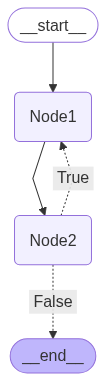

In [140]:
graph

### Run it!
Now, set the thread and run!

In [136]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state

Get the current state. Note the `values` which are the AgentState. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.

In [141]:
snapshot = graph.get_state(thread)
def show_state_in_snapshot(snapshot):
    print(f"State: {state.values}")
    print("***"*20)
show_state_in_snapshot(snapshot)

State: {'count': 0}
************************************************************


View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the *parent_config* is the *config* of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or *time travel* below.

### Look at state history

In [143]:
for state in graph.get_state_history(thread):
    show_state_in_snapshot(state)
    # print(state, "\n")

State: {'lnode': 'node_2', 'scratch': 'hi', 'count': 4}
************************************************************
State: {'lnode': 'node_1', 'scratch': 'hi', 'count': 3}
************************************************************
State: {'lnode': 'node_2', 'scratch': 'hi', 'count': 2}
************************************************************
State: {'lnode': 'node_1', 'scratch': 'hi', 'count': 1}
************************************************************
State: {'scratch': 'hi', 'count': 0}
************************************************************
State: {'count': 0}
************************************************************


Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [144]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-1304-65fc-8004-29e55ec53eca'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-1301-6ef8-8003-836753407bea'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12fd-60a2-8002-7679ae77a784'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12f5-62db-8001-02e5ff013ca8'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12f5-62da-8000-d5e9ca8eba1c'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12f5-62d9-bfff-984924eaa013'}} 0


Grab an early state.

In [145]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f074271-12f5-62db-8001-02e5ff013ca8'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.

In [146]:
state = graph.get_state(states[-3])
show_state_in_snapshot(state)

State: {'lnode': 'node_1', 'scratch': 'hi', 'count': 1}
************************************************************


### Go Back in Time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as *current_state* and continues to node2,

In [147]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

Notice the new states are now in state history. Notice the counts on the far right.

In [148]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-114b-6613-8004-b0f593f3c5dc'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-1148-6d45-8003-07e96e31d8f1'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-1143-691d-8002-6dba5830e603'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-1304-65fc-8004-29e55ec53eca'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-1301-6ef8-8003-836753407bea'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12fd-60a2-8002-7679ae77a784'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12f5-62db-8001-02e5ff013ca8'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074271-12f5-62da-8000-d5e9ca8eba1c'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent *config* is not the previous entry in the stack, but is the entry from state[-3].

In [149]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-114b-6613-8004-b0f593f3c5dc'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-08T07:21:35.631105+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-1148-6d45-8003-07e96e31d8f1'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-1148-6d45-8003-07e96e31d8f1'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-08T07:21:35.630061+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074285-1143-691d-8002-6dba5830e603'}}, tasks=(PregelTask(id='4da5f1aa-604d-588e-e232-2622dc21b928', name='Node2', path=('__pregel_pull

### Modify State
Let's start by starting a fresh thread and running to clean out history.

In [150]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

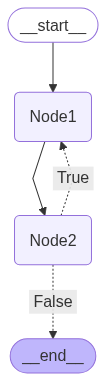

In [152]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [153]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])   

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3371-6f42-8004-123c3ab8d998'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-336f-6605-8003-e632ee298e05'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-336c-6d4a-8002-adbec1108656'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3365-6230-8001-60a173136130'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3362-67a6-8000-3a84d9416b68'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-335e-6438-bfff-ed6cdcc801b5'}} 0


Start by grabbing a state.

In [154]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3365-6230-8001-60a173136130'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-08T07:22:32.893905+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3362-67a6-8000-3a84d9416b68'}}, tasks=(PregelTask(id='90b46929-1f62-58b4-5990-bcdea52b12e6', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are *added* to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [155]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3365-6230-8001-60a173136130'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-08T07:22:32.893905+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074287-3362-67a6-8000-3a84d9416b68'}}, tasks=(PregelTask(id='90b46929-1f62-58b4-5990-bcdea52b12e6', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now update the state. This creates a new entry at the *top*, or *latest* entry in memory. This will become the current state.

In [156]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07428a-51a8-6e05-8005-9aee33287987'}}

Current state is at the top. You can match the `thread_ts`.
Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.

In [160]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07428b-b04a-6ac8-8006-6ac1082d01ff'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2025-08-08T07:24:33.364448+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07428a-51a8-6e05-8005-9aee33287987'}}, tasks=(PregelTask(id='0122f1f4-f9f1-86aa-ba44-a93de889e6b7', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07428a-51a8-6e05-8005-9aee33287987'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2025-08-08T07:23:56.598016+00:00', parent_config={'configurable': {'thread_id': '2', 'ch

### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.

In [161]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f074291-22e0-6a9b-8007-17865b62a816'}}

In [162]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -5}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074291-22e0-6a9b-8007-17865b62a816'}}, metadata={'source': 'update', 'step': 7, 'parents': {}}, created_at='2025-08-08T07:26:59.597378+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07428b-b04a-6ac8-8006-6ac1082d01ff'}}, tasks=(PregelTask(id='93ad2a10-e8aa-4c53-9e07-1f3fa54ab1d3', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07428b-b04a-6ac8-8006-6ac1082d01ff'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2025-08-08T07:24:33.364448+00:00', parent_config={'configurable': {'thread_id': '2', 'c

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [163]:
graph.invoke(None,thread2)

node2, count:-5
node1, count:-4
node2, count:-3
node1, count:-2
node2, count:-1
node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hello', 'count': 4}

Print out the state history, notice the `scratch` value change on the latest entries.

In [164]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074291-e929-6af4-8010-139d26afdec0'}}, metadata={'source': 'loop', 'step': 16, 'parents': {}}, created_at='2025-08-08T07:27:20.389093+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074291-e925-6a5e-800f-42ff90b8c463'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074291-e925-6a5e-800f-42ff90b8c463'}}, metadata={'source': 'loop', 'step': 15, 'parents': {}}, created_at='2025-08-08T07:27:20.387439+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f074291-e923-61dd-800e-5edf19a01442'}}, tasks=(PregelTask(id='b94698b3-8057-7e72-8881-2d6b787d2d85', name='Node2', path=('__pre

Continue to experiment!